**This notebook is for:**
1. Preprocessing variables.

In [1]:
import sys, os 
prj_path = os.path.dirname(os.getcwd())
utils_path = prj_path + '/utils'
if  not utils_path in sys.path:
    print('adding utils to path ')
    sys.path.insert(1, utils_path)

adding utils to path 


In [2]:
from utilities import *

from google_cloud import BigQuery, Storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

import os
import sys

import boto3
import base64

#Cliente BigQuery
AUTH_BIGQUERY = base64.b64decode(os.environ['SECRET_AUTH_BIGQUERY_MODEL'])
bq = BigQuery(AUTH_BIGQUERY)
storage =Storage(AUTH_BIGQUERY)

#Load config.
files = glob.glob(f"{utils_path}/*.yml") 
conf = load_conf(files)

In [ ]:
# !pip install pandas --upgrade

In [3]:
site = conf['SITE']
backbone_table = conf['BACKBONE_TABLE_NAME']
time = ('2022-01-05', '2022-02-23')

In [4]:
master_vars_path = conf['MASTERS_VARS_PATHS']
mater_path_gcp = conf['MASTER_BUCKET_PATH']

prj, bu, model = conf['PROYECT'],conf['BUSINESS_UNIT'],conf['MODEL']
bucket_path = f'{prj}/{bu}/{model}/{site}/'

#temporal_dir = random_name(10)

#### TARGET AND MODEL POPULATION

In [5]:
#Model population.
df = bq.execute_response(f'SELECt * FROM {backbone_table}_{site}')

2022-03-22 09:51:54 This service is instrumented using OpenTelemetry.OpenTelemetry could not be imported; pleaseadd opentelemetry-api and opentelemetry-instrumentationpackages in order to get BigQuery Tracing data.
/usr/local/lib/python3.7/site-packages/google/cloud/bigquery/client.py:445: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [6]:
df.head(3)

,CUS_CUST_ID,SENT_DATE,EVENT_TYPE,CONVERSION
0,1045397197,2022-01-05,sent,0E-9
1,1051004037,2022-01-05,sent,0E-9
2,1025618491,2022-01-05,sent,0E-9


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694536 entries, 0 to 694535
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   CUS_CUST_ID  694536 non-null  int64 
 1   SENT_DATE    694536 non-null  object
 2   EVENT_TYPE   694536 non-null  object
 3   CONVERSION   694536 non-null  object
dtypes: int64(1), object(3)
memory usage: 21.2+ MB


In [8]:
df['SENT_DATE'] = pd.to_datetime(df.SENT_DATE)
df['CONVERSION'] = df['CONVERSION'].astype(np.int64)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694536 entries, 0 to 694535
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CUS_CUST_ID  694536 non-null  int64         
 1   SENT_DATE    694536 non-null  datetime64[ns]
 2   EVENT_TYPE   694536 non-null  object        
 3   CONVERSION   694536 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 21.2+ MB


In [10]:
df.head(3)

,CUS_CUST_ID,SENT_DATE,EVENT_TYPE,CONVERSION
0,1045397197,2022-01-05,sent,0
1,1051004037,2022-01-05,sent,0
2,1025618491,2022-01-05,sent,0


In [11]:
df.groupby('SENT_DATE').CUS_CUST_ID.count().head()

SENT_DATE
2022-01-05    20892
2022-01-06     9986
2022-01-07     6264
2022-01-08    10336
2022-01-09     8931
Name: CUS_CUST_ID, dtype: int64

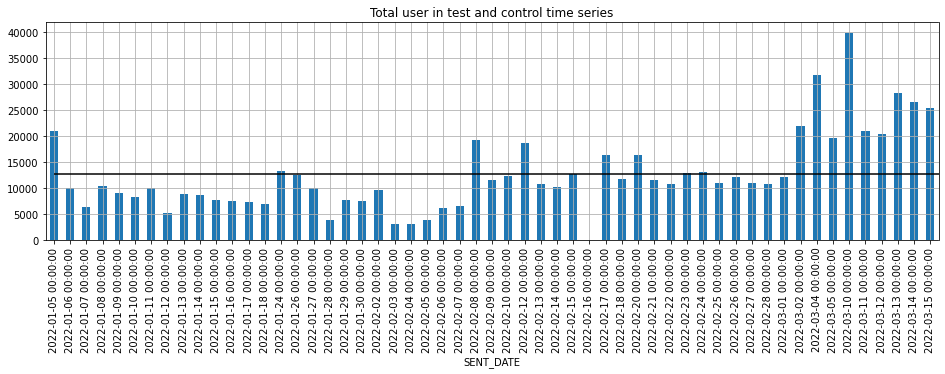

In [14]:
df.groupby('SENT_DATE').CUS_CUST_ID.nunique().plot.bar(figsize=(16,4))
plt.title('Total user in test and control time series')
plt.grid()
#Remover el 2022-02-16
a = df.groupby('SENT_DATE').CUS_CUST_ID.nunique().mean()
plt.hlines(y = a, xmin =0,xmax =60,colors = 'k')

In [15]:
print(f'Average push per day {np.round(a,0)}')

Average push per day 12628.0


In [18]:
df.groupby('SENT_DATE').CONVERSION.mean().head(10)*100

SENT_DATE
2022-01-05    3.446295
2022-01-06    3.835370
2022-01-07    3.288633
2022-01-08    2.650929
2022-01-09    2.900011
2022-01-10    3.382512
2022-01-11    3.696343
2022-01-12    2.608866
2022-01-13    4.031710
2022-01-14    3.400345
Name: CONVERSION, dtype: float64

(0.0, 6.0)

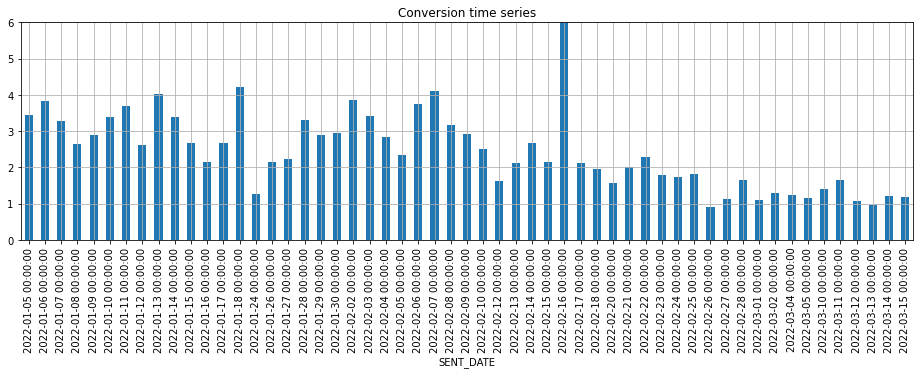

In [19]:
(df.groupby('SENT_DATE').CONVERSION.mean()*100).plot.bar(figsize=(16,4))
plt.grid()
plt.title('Conversion time series')
plt.ylim((0,6))

In [20]:
print(f'Mean conversion rate: {df.CONVERSION.mean()*100}%')

Mean conversion rate: 2.058064664754599%


In [21]:
df.groupby(['SENT_DATE','EVENT_TYPE']).CONVERSION.mean().head()

SENT_DATE   EVENT_TYPE
2022-01-05  control       0.029812
            sent          0.034932
2022-01-06  control       0.045455
            sent          0.037630
2022-01-07  control       0.019070
Name: CONVERSION, dtype: float64

In [22]:
df.groupby(['SENT_DATE','EVENT_TYPE']).CUS_CUST_ID.count().head()

SENT_DATE   EVENT_TYPE
2022-01-05  control        1912
            sent          18980
2022-01-06  control         924
            sent           9062
2022-01-07  control         839
Name: CUS_CUST_ID, dtype: int64

In [23]:
d = df.groupby(['SENT_DATE','EVENT_TYPE']).CUS_CUST_ID.count().reset_index()

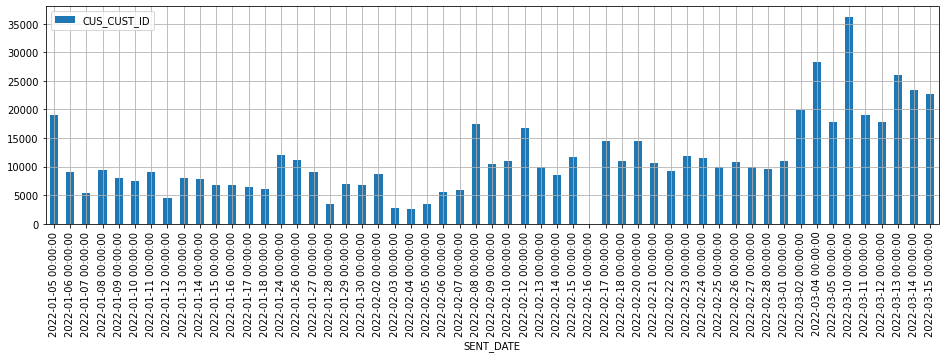

In [24]:
d.loc[d.EVENT_TYPE=='sent'].plot.bar(x = 'SENT_DATE', y = 'CUS_CUST_ID',figsize=(16,4))
plt.grid()

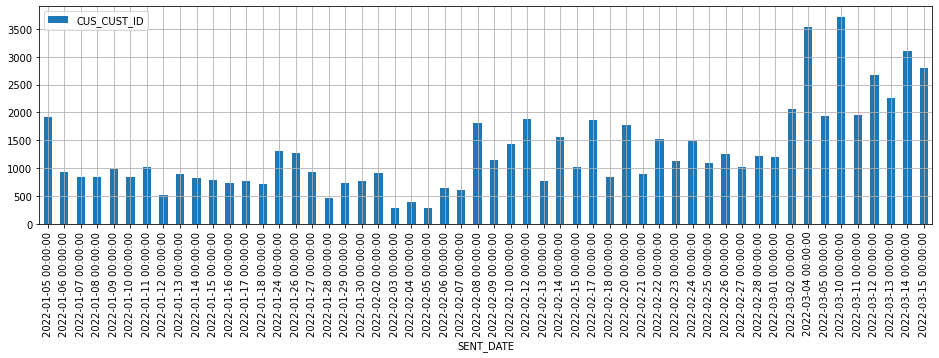

In [25]:
d.loc[d.EVENT_TYPE=='control'].plot.bar(x = 'SENT_DATE', y = 'CUS_CUST_ID',figsize=(16,4))
plt.grid()

In [26]:
prc = d.loc[d.EVENT_TYPE=='control'].CUS_CUST_ID.sum()*100/d.loc[d.EVENT_TYPE=='sent'].CUS_CUST_ID.sum()
print(f'Average percentage of control (pushed users) per sent: {np.round(prc,2)}%')

Average percentage of control (pushed users) per sent: 11.23%


#### PUSH VARS.
- Amount of push notifiations in the last 7 days
- Recency from the last push

In [28]:
#PUSH VARS
temporal_dir = random_name(n=10)
temporal_subdir = f"{temporal_dir}/{conf['PREFIX_MASTERS']['PUSH_VARS']}"
os.makedirs(f"{temporal_subdir}",exist_ok=True)
logger.info(f"Temporal subdir created: {temporal_subdir}.")

2022-03-22 09:53:57 Temporal subdir created: AYcBHxOFfd/PUSHVAR.


In [29]:
download_(temporal_dir = temporal_subdir,
          bucket_path = bucket_path,
          bucket_var = master_vars_path['PUSH_VARS'],
          is_prod = False)

2022-03-22 09:54:01 Looking in: bucket_path: gs://marketing-modelling/ML/NB/MLB/ and subdir /dataset/PUSH_VARS


In [52]:
push_df = pd.read_parquet(f'{temporal_subdir}/000000000000.parquet')

In [53]:
push_df.head(3)

,CUS_CUST_ID,SENT_DATE,R_PUSH_LAST_15D_VS_REST_OF_MONTH,TOTAL_PUSH_LAST_7D,RECENCY
0,1036888090,2022-01-05,0.142857,0,NaN
1,1045840749,2022-01-05,NaN,0,NaN
2,1051024606,2022-01-05,NaN,0,NaN


In [54]:
def proc_pushvars(df:pd.DataFrame)->pd.DataFrame:
    """Pre-processing procedure for push notification variables.
    df: DataFrame with the variables.
    """
    logger.info(f"--------- START PROCESSING PROCEDURE ON PUSHVAR ---------")
    logger.info(f"INPUT DATAFRAME {df.shape} unique users {df.CUS_CUST_ID.nunique()}")
    
    df['SENT_DATE'] = pd.to_datetime(df.SENT_DATE)
    
    recency_na = np.round(df['RECENCY'].isna().mean(),3)*100
    logger.info(f"FILL RECENCY NA VALUES ({recency_na} %) WITH MAX(RECENCY)+1")
    df['RECENCY'] = df['RECENCY'].fillna(np.max(df.RECENCY)+1).astype(np.int64)
    
    r_push_na = np.round(df['R_PUSH_LAST_15D_VS_REST_OF_MONTH'].isna().mean(),3)*100
    logger.info(f"FILL R_PUSH_LAST_15D_VS_REST_OF_MONTH NA ({r_push_na}) VALUES WITH -1")
    df['R_PUSH_LAST_15D_VS_REST_OF_MONTH'] = df['R_PUSH_LAST_15D_VS_REST_OF_MONTH']\
    .fillna(-1).astype(np.int64)
    
    logger.info(f"ADDING VAR R_PUSH_RANK & TOTAL_PUSH_LAST_7D_RANK")
    df['R_PUSH_RANK'] = df['R_PUSH_LAST_15D_VS_REST_OF_MONTH'].rank(na_option='bottom',pct=True)
    df['TOTAL_PUSH_LAST_7D_RANK'] = df['TOTAL_PUSH_LAST_7D'].rank(na_option='bottom',pct=True)
    
    df = prefix_source_info(df = df,
                            prefix = conf['PREFIX_MASTERS']['PUSH_VARS'],
                            exceptions= ['Y','W','SENT_DATE','CUS_CUST_ID'])
    
    logger.info(f"OUTPUT DATAFRAME {df.shape} unique users {df.CUS_CUST_ID.nunique()}")
    logger.info(f"--------- END PROCESSING PROCEDURE ON PUSHVAR ---------")
    return df

In [55]:
push_df = proc_pushvars(push_df)

2022-03-22 10:08:34 --------- START PROCESSING PROCEDURE ON PUSHVAR ---------
2022-03-22 10:08:34 INPUT DATAFRAME (694536, 5) unique users 694536
2022-03-22 10:08:34 FILL RECENCY NA VALUES (18.6 %) WITH MAX(RECENCY)+1
2022-03-22 10:08:34 FILL R_PUSH_LAST_15D_VS_REST_OF_MONTH NA (64.8) VALUES WITH -1
2022-03-22 10:08:34 ADDING VAR R_PUSH_RANK & TOTAL_PUSH_LAST_7D_RANK
2022-03-22 10:08:34 Adding prefix PUSHVAR_ to DataFrame
2022-03-22 10:08:34 OUTPUT DATAFRAME (694536, 7) unique users 694536
2022-03-22 10:08:34 --------- END PROCESSING PROCEDURE ON PUSHVAR ---------


In [56]:
push_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694536 entries, 0 to 694535
Data columns (total 7 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   CUS_CUST_ID                               694536 non-null  int64         
 1   SENT_DATE                                 694536 non-null  datetime64[ns]
 2   PUSHVAR_R_PUSH_LAST_15D_VS_REST_OF_MONTH  694536 non-null  int64         
 3   PUSHVAR_TOTAL_PUSH_LAST_7D                694536 non-null  int64         
 4   PUSHVAR_RECENCY                           694536 non-null  int64         
 5   PUSHVAR_R_PUSH_RANK                       694536 non-null  float64       
 6   PUSHVAR_TOTAL_PUSH_LAST_7D_RANK           694536 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 37.1 MB


In [50]:
push_df.PUSHVAR_R_PUSH_RANK

0         0.715074
1         0.324189
2         0.324189
3         0.324189
4         0.324189
            ...   
694531    0.991441
694532    0.953802
694533    0.839603
694534    0.953802
694535    0.971675
Name: PUSHVAR_R_PUSH_RANK, Length: 694536, dtype: float64

In [ ]:
push_df['SENT_DATE'] = pd.to_datetime(push_df.SENT_DATE)
push_df['RECENCY'] = push_df['RECENCY'].fillna(np.max(push_df.RECENCY)+1).astype(np.int64)

In [ ]:
push_df.info()

In [58]:
push_df['PUSHVAR_TOTAL_PUSH_LAST_7D'].value_counts(normalize=True).sort_index()

0    0.186392
1    0.245623
2    0.240314
3    0.133842
4    0.068777
5    0.054500
6    0.045609
7    0.024943
Name: PUSHVAR_TOTAL_PUSH_LAST_7D, dtype: float64

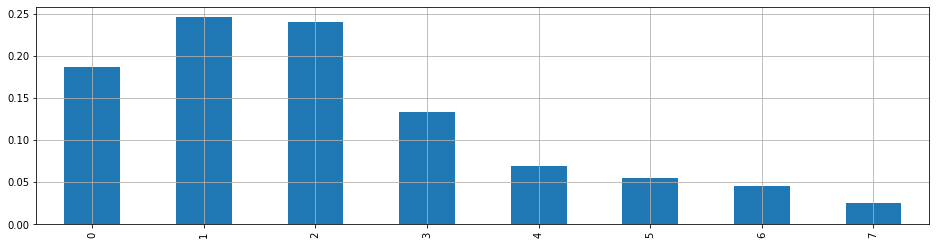

In [59]:
push_df['PUSHVAR_TOTAL_PUSH_LAST_7D'].value_counts(normalize=True).sort_index().plot.bar(figsize=(16,4))
plt.grid()

In [61]:
push_df['PUSHVAR_RECENCY'].value_counts(normalize=True).sort_index()

1    0.434578
2    0.156617
3    0.093677
4    0.050000
5    0.029852
6    0.028073
7    0.020811
8    0.186392
Name: PUSHVAR_RECENCY, dtype: float64

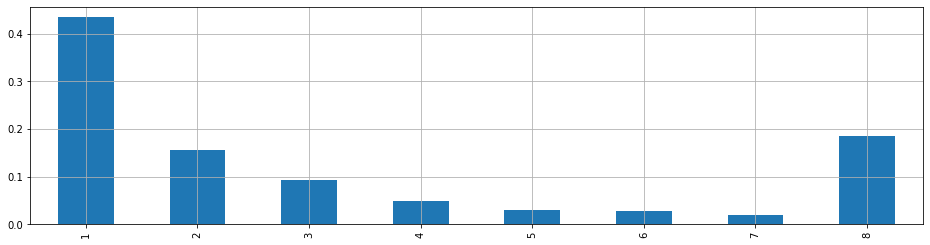

In [62]:
push_df['PUSHVAR_RECENCY'].value_counts(normalize=True).sort_index().plot.bar(figsize=(16,4))
plt.grid()
#El valor de 8 es la imputacion. 

In [ ]:
push_df.shape

In [ ]:
push_df = prefix_source_info(df = push_df,
                             prefix = conf['PREFIX_MASTERS']['PUSH_VARS'],
                             exceptions= ['Y','W','SENT_DATE','CUS_CUST_ID'])

In [ ]:
# def proc_pushvars(df:pd.DataFrame)->pd.DataFrame:
#     """Pre-processing procedure for push notification variables.
#     df: DataFrame with the variables.
#     """
#     logger.info(f"START PROCESSING PROCEDURE ON PUSHVAR")
#     logger.info(f"INPUT DATAFRAME {df.shape} unique users {df.CUS_CUST_ID.nunique()}")
    
#     df['SENT_DATE'] = pd.to_datetime(df.SENT_DATE)
#     logger.info(f"FILL RECENCY NA VALUES WITH MAX(RECENCY)+1")
#     df['RECENCY'] = df['RECENCY'].fillna(np.max(df.RECENCY)+1).astype(np.int64)
    
#     df = prefix_source_info(df = df,
#                              prefix = conf['PREFIX_MASTERS']['PUSH_VARS'],
#                              exceptions= ['Y','W','SENT_DATE','CUS_CUST_ID'])
#     return df

In [ ]:
push_df.head()

#### BEHAVIOUR_VARS.

In [63]:
#BEHAVIOUR_VARS
temporal_subdir = f"{temporal_dir}/{conf['PREFIX_MASTERS']['BEHAVIOUR_VARS']}"
os.makedirs(f"{temporal_subdir}",exist_ok=True)
logger.info(f"Temporal subdir created: {temporal_subdir}.")

2022-03-22 10:35:25 Temporal subdir created: AYcBHxOFfd/BEHAVIOURVARS.


In [64]:
download_(temporal_dir = temporal_subdir,
          bucket_path = bucket_path,
          bucket_var = master_vars_path['BEHAVIOUR_VARS'],
          is_prod = False)

2022-03-22 10:35:30 Looking in: bucket_path: gs://marketing-modelling/ML/NB/MLB/ and subdir /dataset/BEHAVIOUR_VARS


In [73]:
beha_df = pd.read_parquet(f'{temporal_dir}/BEHAVIOURVARS/000000000000.parquet')

In [74]:
beha_df.describe()

,CUS_CUST_ID,LOG_DATE_COUNT_7D,RECENCY,CAT_CATEG_ID_COUNT_7D,BUY_INTENTION_ITEM_COUNT,CAT_CATEG_ID_COUNT_F7D,VIP_VIEW_APP_ANDROID_ITEM_COUNT,VIP_VIEW_APP_IOS_ITEM_COUNT,VIP_VIEW_DESKTOP_ITEM_COUNT,VIP_VIEW_WEB_MOBILE_ITEM_COUNT,...,CHECKOUT_CONGRATS_ITEM_COUNT,ADD_TO_CART_ITEM_COUNT,BOOKMARK_ITEM_COUNT,APP_ML,APP_MP,MAX_FROM_INSTALL_ML,MIN_FROM_INSTALL_ML,MAX_FROM_INSTALL_MP,MIN_FROM_INSTALL_MP,TOTAL_PAYMENTS_COUNT
count,6.945360e+05,694536.000000,542325.000000,694536.000000,694536.000000,694536.000000,694536.000000,694536.000000,694536.000000,694536.000000,...,694536.000000,694536.000000,694536.000000,694536.000000,694536.000000,451414.000000,451414.000000,157295.000000,157295.000000,694536.000000
mean,1.022526e+09,1.585666,1.790024,6.896946,1.153287,2.290811,15.049118,0.722193,0.368041,0.098555,...,0.216350,0.084436,1.107195,0.649950,0.226475,28.722007,29.585700,28.507467,29.731295,0.329708
std,1.376240e+08,1.388921,1.267384,34.558315,11.905013,9.393030,91.506409,24.047597,12.009012,6.649259,...,2.221335,1.523868,18.488043,0.476986,0.418550,35.361741,36.186447,31.219454,32.343751,4.153295
min,-1.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.047327e+09,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,7.000000,7.000000,0.000000
50%,1.062878e+09,1.000000,1.000000,3.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,18.000000,21.000000,23.000000,0.000000
75%,1.076315e+09,2.000000,2.000000,7.000000,1.000000,2.000000,13.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,41.000000,42.000000,42.000000,43.000000,0.000000
max,1.089430e+09,7.000000,7.000000,14478.000000,7020.000000,4608.000000,43434.000000,13536.000000,5568.000000,4680.000000,...,762.000000,460.000000,5964.000000,1.000000,1.000000,360.000000,360.000000,360.000000,360.000000,2413.000000


In [75]:
series = beha_df.OS_NAME

In [76]:
x = np.round(series.isnull().mean(),2)

In [79]:
logger.info(f"% OF NaN in {series.name}: {x} %")

2022-03-22 13:35:06 % OF NaN in OS_NAME: 0.29 %


In [81]:
class_p = series.value_counts(normalize=True).to_dict()

In [84]:
proportions=class_p

In [85]:
rv = np.random.choice(a = [*proportions.keys()],
                      size = series.isna().sum(),
                      p = [*proportions.values()]
                     ) 

In [86]:
rv

array(['android', 'android', 'android', ..., 'android', 'android',
       'android'], dtype='<U7')

In [ ]:
ix = np.arange(0,len(series))
series_ = series.copy()
for x,y,z in zip(ix,series.isna(),rv):
    if y:
        series_.iloc[x] = z

In [ ]:
series = beha_df.OS_NAME
x = np.round(series.isnull().mean(),2)
logger.info(f"% OF NaN in {series.name}: {x}")
rv = np.random.choice(a = [*proportions.keys()],
                      size = series.isna().sum(),
                      p = [*proportions.values()]
                     ) 
series.loc[series.isna()] = rv

In [ ]:
['LOG_DATE_COUNT_7D', 'AVG_PRICE_ITEM_7D','CAT_CATEG_ID_COUNT_7D', 'AVG_PRICE_ITEM_F7D',
       'MIN_PRICE_ITEM', 'MAX_PRICE_ITEM', 'BUY_INTENTION_ITEM_COUNT',
       'CAT_CATEG_ID_COUNT_F7D', 'VIP_VIEW_APP_ANDROID_ITEM_COUNT',
       'VIP_VIEW_APP_IOS_ITEM_COUNT', 'VIP_VIEW_DESKTOP_ITEM_COUNT',
       'VIP_VIEW_WEB_MOBILE_ITEM_COUNT', 'VIP_VIEW', 'QUESTION_ITEM_COUNT',
       'CHECKOUT_CONGRATS_ITEM_COUNT', 'ADD_TO_CART_ITEM_COUNT',
       'BOOKMARK_ITEM_COUNT', 'TOTAL_PAYMENTS_AMT_SUM',
       'WALLET_PAYMENTS_AMT_SUM', 'AGGREGATOR_PAYMENTS_AMT_SUM',
       'TOTAL_PAYMENTS_COUNT']

In [ ]:
beha_df.max(axis =0)

In [ ]:
beha_df.columns

In [ ]:
beha_df.info()

In [ ]:
#CASTEOS.
beha_df['SENT_DATE'] = pd.to_datetime(beha_df.SENT_DATE)
beha_df['MIN_PRICE_ITEM'] = beha_df['MIN_PRICE_ITEM'].astype(np.float64)
beha_df['MAX_PRICE_ITEM'] = beha_df['MAX_PRICE_ITEM'].astype(np.float64)
beha_df['TOTAL_PAYMENTS_AMT_SUM'] = beha_df['TOTAL_PAYMENTS_AMT_SUM'].astype(np.float64)
beha_df['WALLET_PAYMENTS_AMT_SUM'] = beha_df['WALLET_PAYMENTS_AMT_SUM'].astype(np.float64)
beha_df['AGGREGATOR_PAYMENTS_AMT_SUM'] = beha_df['AGGREGATOR_PAYMENTS_AMT_SUM'].astype(np.float64)
beha_df['AVG_PRICE_ITEM_7D'] = beha_df['AVG_PRICE_ITEM_7D'].astype(np.float64)
beha_df['AVG_PRICE_ITEM_F7D'] = beha_df['AVG_PRICE_ITEM_F7D'].astype(np.float64)

In [ ]:
beha_df.info()

In [ ]:
beha_df.head(3)

In [ ]:
beha_df['MIN_PRICE_ITEM']

In [ ]:
beha_df['MIN_PRICE_ITEM'] = beha_df['MIN_PRICE_ITEM'].astype(np.float64)
beha_df.boxplot(column = 'MIN_PRICE_ITEM')

In [ ]:
def outlier_clipping(series:pd.Series,q:float = .95):
    """Replace the values over the percentile 95 with the value
    of this percentile."""
    
    top = np.nanquantile(series,q)
    logger.info(f"{series.name} - MAX : {np.max(series)} WILL BE REPALCED BY {top}")
    series.loc[series > top] = top
    
    return series        

In [ ]:
beha_df['MIN_PRICE_ITEM'] = beha_df['MIN_PRICE_ITEM'].astype(np.float64)
beha_df['MAX_PRICE_ITEM'] = beha_df['MAX_PRICE_ITEM'].astype(np.float64)
for col in ['MIN_PRICE_ITEM','MAX_PRICE_ITEM']:
    beha_df[col] =  outlier_clipping(beha_df[col].copy(),q = .95)

In [ ]:
beha_df.boxplot(column = 'MIN_PRICE_ITEM')

In [ ]:
beha_df.boxplot(column = 'MAX_PRICE_ITEM')

In [ ]:
beha_df.info()

In [ ]:
cols = ['MIN_PRICE_ITEM','MAX_PRICE_ITEM',
        'MAX_FROM_INSTALL_ML','MIN_FROM_INSTALL_ML',
        'MAX_FROM_INSTALL_MP','MIN_FROM_INSTALL_MP']
for col in cols:
    logger.info(f"FILL NA {col} ({np.round(beha_df[col].isna().mean(),2)*100}%) VALUES WITH -1")
    beha_df[col] = beha_df[col].fillna(-1)

In [ ]:
beha_df['SENT_DATE'] = pd.to_datetime(beha_df.SENT_DATE)
beha_df['MIN_PRICE_ITEM'] = beha_df['MIN_PRICE_ITEM'].astype(np.float64)
beha_df['MAX_PRICE_ITEM'] = beha_df['MAX_PRICE_ITEM'].astype(np.float64)
beha_df['TOTAL_PAYMENTS_AMT_SUM'] = beha_df['TOTAL_PAYMENTS_AMT_SUM'].astype(np.float64)
beha_df['WALLET_PAYMENTS_AMT_SUM'] = beha_df['WALLET_PAYMENTS_AMT_SUM'].astype(np.float64)
beha_df['AGGREGATOR_PAYMENTS_AMT_SUM'] = beha_df['AGGREGATOR_PAYMENTS_AMT_SUM'].astype(np.float64)
beha_df['AVG_PRICE_ITEM_7D'] = beha_df['AVG_PRICE_ITEM_7D'].astype(np.float64)
beha_df['AVG_PRICE_ITEM_F7D'] = beha_df['AVG_PRICE_ITEM_F7D'].astype(np.float64)

beha_df['RECENCY'] = beha_df['RECENCY'].fillna(np.max(beha_df.RECENCY) + 1).astype(np.int64)

#carefull
beha_df['MIN_PRICE_ITEM'] = beha_df['MIN_PRICE_ITEM'].fillna(-1)
beha_df['MAX_PRICE_ITEM'] = beha_df['MAX_PRICE_ITEM'].fillna(-1)
beha_df['MAX_FROM_INSTALL_ML'] = beha_df['MAX_FROM_INSTALL_ML'].fillna(-1)
beha_df['MIN_FROM_INSTALL_ML'] = beha_df['MIN_FROM_INSTALL_ML'].fillna(-1)
beha_df['MAX_FROM_INSTALL_MP'] = beha_df['MAX_FROM_INSTALL_MP'].fillna(-1)
beha_df['MIN_FROM_INSTALL_MP'] = beha_df['MIN_FROM_INSTALL_MP'].fillna(-1)

In [ ]:
beha_df.info()

In [ ]:
beha_df['OS_NAME'].value_counts(normalize=True)

In [ ]:
class_p = beha_df['OS_NAME'].value_counts(normalize=True).to_dict()
categorical_imputer(series = beha_df['OS_NAME'],proportions = class_p)

In [ ]:
beha_df['OS_NAME'].value_counts(normalize=True)

In [ ]:
beha_df['OS_IS_ANDROID'] = remap_column(serie = beha_df['OS_NAME'],dict_ = {'android':1, 'ios':0})

In [ ]:
beha_df['OS_IS_ANDROID'].value_counts(normalize=True)

In [ ]:
beha_df.drop(columns='OS_NAME', inplace=True)

In [ ]:
beha_df = prefix_source_info(df = beha_df,
                             prefix = conf['PREFIX_MASTERS']['BEHAVIOUR_VARS'],
                             exceptions= ['Y','W','SENT_DATE','CUS_CUST_ID'])

In [ ]:
beha_df.shape

In [ ]:
beha_df.head()

In [72]:
 beha_df.BEHAVIOURVARS_OS_NAME

AttributeError: 'DataFrame' object has no attribute 'BEHAVIOURVARS_OS_NAME'

In [ ]:
x = np.round(series.isnull().mean(),2)
logger.info(f"% OF NaN in {series.name}: {x}")
rv = np.random.choice(a = [*proportions.keys()],
                      size = series.isna().sum(),
                      p = [*proportions.values()]
                     ) 
series.loc[series.isna()] = rv

In [68]:
def proc_behaviour(df: pd.DataFrame)->pd.DataFrame:
    """Pre-processing procedure for events on :
    marketplace and MP app.
    df: DataFrame with the variables.
    """
    logger.info(f"--------- START PROCESSING PROCEDURE ON BEHAVIOUR ---------")
    logger.info(f"INPUT DATAFRAME {df.shape} unique users {df.CUS_CUST_ID.nunique()}")
    
    logger.info(f"CAST VARIABLES TYPE")
    df['SENT_DATE'] = pd.to_datetime(df.SENT_DATE)
    df['MIN_PRICE_ITEM'] = df['MIN_PRICE_ITEM'].astype(np.float64)
    df['MAX_PRICE_ITEM'] = df['MAX_PRICE_ITEM'].astype(np.float64)
    df['TOTAL_PAYMENTS_AMT_SUM'] = df['TOTAL_PAYMENTS_AMT_SUM'].astype(np.float64)
    df['WALLET_PAYMENTS_AMT_SUM'] = df['WALLET_PAYMENTS_AMT_SUM'].astype(np.float64)
    df['AGGREGATOR_PAYMENTS_AMT_SUM'] = df['AGGREGATOR_PAYMENTS_AMT_SUM'].astype(np.float64)
    df['AVG_PRICE_ITEM_7D'] = df['AVG_PRICE_ITEM_7D'].astype(np.float64)
    df['AVG_PRICE_ITEM_F7D'] = df['AVG_PRICE_ITEM_F7D'].astype(np.float64)
    
    logger.info(f"Clipping prices and money by percentil 95")
    cols = ['AVG_PRICE_ITEM_7D','CAT_CATEG_ID_COUNT_7D', 
            'AVG_PRICE_ITEM_F7D','MIN_PRICE_ITEM', 'MAX_PRICE_ITEM', 
            'BUY_INTENTION_ITEM_COUNT','CAT_CATEG_ID_COUNT_F7D', 
            'VIP_VIEW_APP_ANDROID_ITEM_COUNT','VIP_VIEW_APP_IOS_ITEM_COUNT',
            'VIP_VIEW_DESKTOP_ITEM_COUNT','VIP_VIEW_WEB_MOBILE_ITEM_COUNT', 
            'VIP_VIEW', 'QUESTION_ITEM_COUNT','CHECKOUT_CONGRATS_ITEM_COUNT',
            'ADD_TO_CART_ITEM_COUNT','BOOKMARK_ITEM_COUNT', 
            'TOTAL_PAYMENTS_AMT_SUM','WALLET_PAYMENTS_AMT_SUM', 
            'AGGREGATOR_PAYMENTS_AMT_SUM','TOTAL_PAYMENTS_COUNT']
    for col in cols:
        df[col] =  outlier_clipping(df[col].copy(),q = .95)
    
    recency_na = np.round(df['RECENCY'].isna().mean(),3)*100
    logger.info(f"FILL RECENCY NA VALUES ({recency_na} %) WITH MAX(RECENCY)+1")
    df['RECENCY'] = df['RECENCY'].fillna(np.max(df.RECENCY) + 1).astype(np.int64)

    cols = ['MIN_PRICE_ITEM','MAX_PRICE_ITEM',
            'MAX_FROM_INSTALL_ML','MIN_FROM_INSTALL_ML',
            'MAX_FROM_INSTALL_MP','MIN_FROM_INSTALL_MP']
    for col in cols:
        logger.info(f"FILL NA {col} ({np.round(df[col].isna().mean(),2)*100}%) VALUES WITH -1")
        df[col] = df[col].fillna(-1)
    
    od_na = np.round(df['OS_NAME'].isna().mean(),3)*100
    logger.info(f"FILL NA VALUES IN OS_NAME ({od_na}%) BY ORIGINAL DISTIRBUTION")
    class_p = df['OS_NAME'].value_counts(normalize=True).to_dict()
    categorical_imputer(series = df['OS_NAME'],proportions = class_p)
    df['OS_IS_ANDROID'] = remap_column(serie = df['OS_NAME'],dict_ = {'android':1, 'ios':0})
    df.drop(columns='OS_NAME', inplace=True)
    
    df = prefix_source_info(df = df,
                            prefix = conf['PREFIX_MASTERS']['BEHAVIOUR_VARS'],
                            exceptions= ['Y','W','SENT_DATE','CUS_CUST_ID'])
    
    logger.info(f"OUTPUT DATAFRAME {df.shape} unique users {df.CUS_CUST_ID.nunique()}")
    logger.info(f"--------- END PROCESSING PROCEDURE ON BEHAVIOUR ---------")
    return df

In [69]:
beha_df = proc_behaviour(beha_df)

2022-03-22 10:41:33 --------- START PROCESSING PROCEDURE ON BEHAVIOUR ---------
2022-03-22 10:41:33 INPUT DATAFRAME (694536, 31) unique users 694536
2022-03-22 10:41:33 CAST VARIABLES TYPE
2022-03-22 10:41:35 Clipping prices and money by percentil 95
2022-03-22 10:41:35 AVG_PRICE_ITEM_7D - MAX : 970829436.5925379 WILL BE REPALCED BY 1291.68875
2022-03-22 10:41:35 CAT_CATEG_ID_COUNT_7D - MAX : 14478 WILL BE REPALCED BY 23.0
2022-03-22 10:41:35 AVG_PRICE_ITEM_F7D - MAX : 666683329.3333334 WILL BE REPALCED BY 612.70485769125
2022-03-22 10:41:35 MIN_PRICE_ITEM - MAX : 970162969.0 WILL BE REPALCED BY 514.0
2022-03-22 10:41:35 MAX_PRICE_ITEM - MAX : 9999999900.0 WILL BE REPALCED BY 5078.0
2022-03-22 10:41:35 BUY_INTENTION_ITEM_COUNT - MAX : 7020 WILL BE REPALCED BY 4.0
2022-03-22 10:41:35 CAT_CATEG_ID_COUNT_F7D - MAX : 4608 WILL BE REPALCED BY 12.0
2022-03-22 10:41:35 VIP_VIEW_APP_ANDROID_ITEM_COUNT - MAX : 43434 WILL BE REPALCED BY 56.0
2022-03-22 10:41:35 VIP_VIEW_APP_IOS_ITEM_COUNT - MAX 

#### MERGE.

In [ ]:
master = df.merge(push_df,on = ['CUS_CUST_ID','SENT_DATE'], how = 'left', validate='1:1')
master = master.merge(beha_df,on = ['CUS_CUST_ID','SENT_DATE'], how = 'left', validate='1:1')

In [ ]:
master.head(3)

In [ ]:
master.info()

In [ ]:
master['W'] = remap_column(serie = master['EVENT_TYPE'],dict_ = {'sent':1, 'control':0})
master.drop(columns='EVENT_TYPE', inplace=True)
master.rename(columns={"CONVERSION": "Y"}, inplace=True)

In [ ]:
master.info()

In [ ]:
master.W.value_counts(normalize=True)

In [ ]:
master.Y.value_counts(normalize=True)